In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd
import sys
import networkx as nx
import os
import warnings
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter'
sys.path.append(ROOT_PACKAGE_DIRECTORY)
# Experiment Graph
from experiment_graph.execution_environment import ExecutionEnvironment as ee
# Suppress warnings
warnings.filterwarnings('ignore')
% matplotlib inline

In [2]:
root_data = ROOT_PACKAGE_DIRECTORY + '/data/home-credit-default-risk'
DATABASE_PATH = ROOT_PACKAGE_DIRECTORY + '/data/environment_same_workload'

In [3]:
# Read in bureau
bureau = ee.load(root_data + '/bureau.csv')
bureau.head().data()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [4]:
previous_loan_counts = bureau.groupby('SK_ID_CURR')['SK_ID_BUREAU'].count()
previous_loan_counts.set_columns(columns=['SK_ID_CURR', 'previous_loan_counts'])
previous_loan_counts.head().data()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [5]:
# Join to the training dataframe
train = ee.load(root_data + '/application_train.csv')
train = train.merge(previous_loan_counts, on='SK_ID_CURR', how='left')

In [6]:
train = train.replace_columns('previous_loan_counts',
                              train['previous_loan_counts'].fillna(0))
train.head().data()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
 # Plots the distribution of a variable colored by value of the target
def kde_target(var_name, df):
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])

    # Calculate medians for repaid vs not repaid
    avg_repaid = df[df['TARGET'] == 0][var_name].median()
    avg_not_repaid = df[df['TARGET'] == 1][var_name].median()

    plt.figure(figsize=(12, 6))

    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df[df['TARGET'] == 0][var_name].dropna().data(), label='TARGET == 0')
    sns.kdeplot(df[df['TARGET'] == 1][var_name].dropna().data(), label='TARGET == 1')

    # label the plot
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('%s Distribution' % var_name)
    plt.legend()

    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr.data()))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid.data())
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid.data())

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


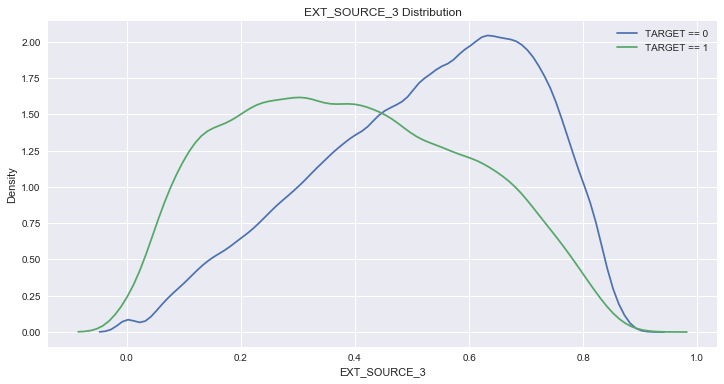

In [8]:
kde_target('EXT_SOURCE_3', train)

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


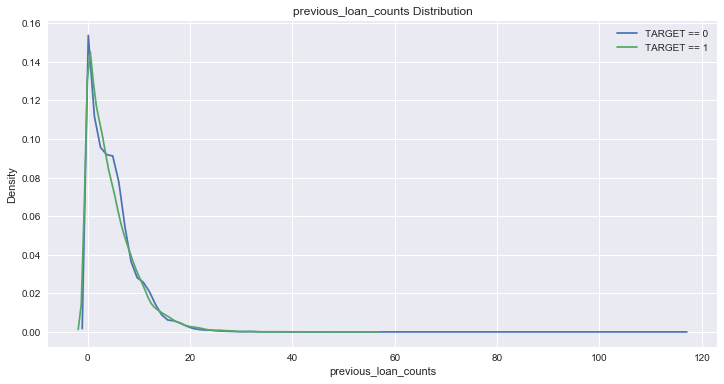

In [9]:
kde_target('previous_loan_counts', train)

In [10]:
# Group by the client id, calculate aggregation statistics
bureau_agg = bureau.drop(columns=['SK_ID_BUREAU']).groupby('SK_ID_CURR').agg(
    ['count', 'mean', 'max', 'min', 'sum'])
columns = []
for c in bureau_agg.data().columns:
    if c != 'SK_ID_CURR':
        columns.append('bureau_{}'.format(c))
    else:
        columns.append(c)
bureau_agg.set_columns(columns)
bureau_agg.head().data()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [11]:
# Merge with the training data
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head().data()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


In [12]:
# List of new correlations
new_corrs = []
columns = bureau_agg.data().columns
# Iterate through the columns 
for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    
    # Append the list as a tuple

    new_corrs.append((col, corr.data()))

In [13]:
# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.089728967219981276),
 ('bureau_DAYS_CREDIT_min', 0.075248251030103866),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.068927352669686762),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.055887379843920323),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.053734895601020578),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758576),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997315),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111597),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.046982754334835487),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730259),
 ('bureau_DAYS_CREDIT_sum', 0.041999824814846737),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.041403635353060082),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329192),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921616135),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325526)]

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


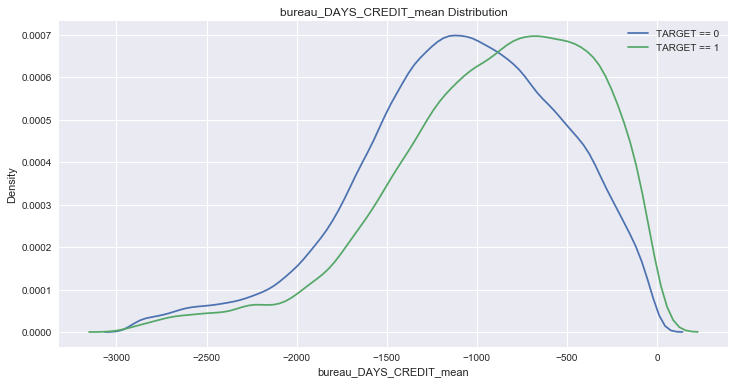

In [14]:
kde_target('bureau_DAYS_CREDIT_mean', train)

In [15]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    df_columns = df.data().columns
    # Remove id variables other than grouping variable
    for col in df_columns:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
    
    numeric_df = df.select_dtypes('number')

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    column_names = [group_var]
    columns = agg.data().columns
    for c in columns:
        if c != group_var:
            column_names.append('{}_{}'.format(df_name, c))
    agg.set_columns(column_names)
    return agg

In [16]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head().data()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [17]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df):

    # List of correlations
    corrs = []
    columns = df.data().columns()
    # Iterate through the columns 
    for col in columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr.data()))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

In [18]:
categorical =  bureau.select_dtypes('object').onehot_encode()
categorical = categorical.add_columns('SK_ID_CURR',bureau['SK_ID_CURR'])
categorical.head().data()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [19]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head().data()

,SK_ID_CURR,CREDIT_ACTIVE_Active_sum,CREDIT_ACTIVE_Active_mean,CREDIT_ACTIVE_Bad debt_sum,CREDIT_ACTIVE_Bad debt_mean,CREDIT_ACTIVE_Closed_sum,CREDIT_ACTIVE_Closed_mean,CREDIT_ACTIVE_Sold_sum,CREDIT_ACTIVE_Sold_mean,CREDIT_CURRENCY_currency 1_sum,...,CREDIT_TYPE_Microloan_sum,CREDIT_TYPE_Microloan_mean,CREDIT_TYPE_Mobile operator loan_sum,CREDIT_TYPE_Mobile operator loan_mean,CREDIT_TYPE_Mortgage_sum,CREDIT_TYPE_Mortgage_mean,CREDIT_TYPE_Real estate loan_sum,CREDIT_TYPE_Real estate loan_mean,CREDIT_TYPE_Unknown type of loan_sum,CREDIT_TYPE_Unknown type of loan_mean
0,100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
3,100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
4,100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [20]:
train = train.merge(categorical_grouped, on = 'SK_ID_CURR', how = 'left')
train.head().data()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_sum,CREDIT_TYPE_Microloan_mean,CREDIT_TYPE_Mobile operator loan_sum,CREDIT_TYPE_Mobile operator loan_mean,CREDIT_TYPE_Mortgage_sum,CREDIT_TYPE_Mortgage_mean,CREDIT_TYPE_Real estate loan_sum,CREDIT_TYPE_Real estate loan_mean,CREDIT_TYPE_Unknown type of loan_sum,CREDIT_TYPE_Unknown type of loan_mean
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
train.shape().data()

(307511, 229)

In [22]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = df.select_dtypes('object').onehot_encode()

    # Make sure to put the identifying id on the column
    categorical = categorical.add_columns(group_var,df[group_var])

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = [group_var]
        # Need to create new column names
    columns = categorical.data().columns
    for c in columns:
        if c != group_var:
            column_names.append('{}_{}'.format(df_name, c))
            
    categorical.set_columns(column_names)
    return categorical

In [23]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head().data()

,SK_ID_CURR,CREDIT_ACTIVE_Active_sum,CREDIT_ACTIVE_Active_mean,CREDIT_ACTIVE_Bad debt_sum,CREDIT_ACTIVE_Bad debt_mean,CREDIT_ACTIVE_Closed_sum,CREDIT_ACTIVE_Closed_mean,CREDIT_ACTIVE_Sold_sum,CREDIT_ACTIVE_Sold_mean,CREDIT_CURRENCY_currency 1_sum,...,CREDIT_TYPE_Microloan_sum,CREDIT_TYPE_Microloan_mean,CREDIT_TYPE_Mobile operator loan_sum,CREDIT_TYPE_Mobile operator loan_mean,CREDIT_TYPE_Mortgage_sum,CREDIT_TYPE_Mortgage_mean,CREDIT_TYPE_Real estate loan_sum,CREDIT_TYPE_Real estate loan_mean,CREDIT_TYPE_Unknown type of loan_sum,CREDIT_TYPE_Unknown type of loan_mean
0,100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
3,100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
4,100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [24]:
# Read in bureau balance
bureau_balance = ee.load(root_data +'/bureau_balance.csv')
bureau_balance.head().data()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [25]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head().data()

,SK_ID_BUREAU,bureau_balance_STATUS_0_sum,bureau_balance_STATUS_0_mean,bureau_balance_STATUS_1_sum,bureau_balance_STATUS_1_mean,bureau_balance_STATUS_2_sum,bureau_balance_STATUS_2_mean,bureau_balance_STATUS_3_sum,bureau_balance_STATUS_3_mean,bureau_balance_STATUS_4_sum,bureau_balance_STATUS_4_mean,bureau_balance_STATUS_5_sum,bureau_balance_STATUS_5_mean,bureau_balance_STATUS_C_sum,bureau_balance_STATUS_C_mean,bureau_balance_STATUS_X_sum,bureau_balance_STATUS_X_mean
0,5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
1,5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
2,5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
3,5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
4,5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [26]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head().data()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [27]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, on = 'SK_ID_BUREAU', how = 'outer')

In [28]:
# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head().data()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_sum,bureau_balance_STATUS_0_mean,bureau_balance_STATUS_1_sum,bureau_balance_STATUS_1_mean,...,bureau_balance_STATUS_3_mean,bureau_balance_STATUS_4_sum,bureau_balance_STATUS_4_mean,bureau_balance_STATUS_5_sum,bureau_balance_STATUS_5_mean,bureau_balance_STATUS_C_sum,bureau_balance_STATUS_C_mean,bureau_balance_STATUS_X_sum,bureau_balance_STATUS_X_mean,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [29]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head().data()


,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_sum_count,client_bureau_balance_STATUS_X_sum_mean,client_bureau_balance_STATUS_X_sum_max,client_bureau_balance_STATUS_X_sum_min,client_bureau_balance_STATUS_X_sum_sum,client_bureau_balance_STATUS_X_mean_count,client_bureau_balance_STATUS_X_mean_mean,client_bureau_balance_STATUS_X_mean_max,client_bureau_balance_STATUS_X_mean_min,client_bureau_balance_STATUS_X_mean_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


In [30]:
# Read in new copies of all the dataframes
train = ee.load(root_data + '/application_train.csv')
bureau = ee.load(root_data +'/bureau.csv')
bureau_balance = ee.load(root_data +'/bureau_balance.csv')

In [31]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head().data()

,SK_ID_CURR,CREDIT_ACTIVE_Active_sum,CREDIT_ACTIVE_Active_mean,CREDIT_ACTIVE_Bad debt_sum,CREDIT_ACTIVE_Bad debt_mean,CREDIT_ACTIVE_Closed_sum,CREDIT_ACTIVE_Closed_mean,CREDIT_ACTIVE_Sold_sum,CREDIT_ACTIVE_Sold_mean,CREDIT_CURRENCY_currency 1_sum,...,CREDIT_TYPE_Microloan_sum,CREDIT_TYPE_Microloan_mean,CREDIT_TYPE_Mobile operator loan_sum,CREDIT_TYPE_Mobile operator loan_mean,CREDIT_TYPE_Mortgage_sum,CREDIT_TYPE_Mortgage_mean,CREDIT_TYPE_Real estate loan_sum,CREDIT_TYPE_Real estate loan_mean,CREDIT_TYPE_Unknown type of loan_sum,CREDIT_TYPE_Unknown type of loan_mean
0,100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
3,100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
4,100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [32]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head().data()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [33]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head().data()

,SK_ID_BUREAU,bureau_balance_STATUS_0_sum,bureau_balance_STATUS_0_mean,bureau_balance_STATUS_1_sum,bureau_balance_STATUS_1_mean,bureau_balance_STATUS_2_sum,bureau_balance_STATUS_2_mean,bureau_balance_STATUS_3_sum,bureau_balance_STATUS_3_mean,bureau_balance_STATUS_4_sum,bureau_balance_STATUS_4_mean,bureau_balance_STATUS_5_sum,bureau_balance_STATUS_5_mean,bureau_balance_STATUS_C_sum,bureau_balance_STATUS_C_mean,bureau_balance_STATUS_X_sum,bureau_balance_STATUS_X_mean
0,5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
1,5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
2,5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
3,5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
4,5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [34]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head().data()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [35]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(
    bureau_balance_counts, on='SK_ID_BUREAU', how='outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(
    bureau_by_loan, on='SK_ID_BUREAU', how='left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(
    bureau_by_loan.drop(columns=['SK_ID_BUREAU']),
    group_var='SK_ID_CURR',
    df_name='client')

In [36]:
original_features = list(train.data().columns)
print('Original Number of Features: ', len(original_features))

('Original Number of Features: ', 122)


In [37]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [38]:
new_features = list(train.data().columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

('Number of features using previous loans from other institutions data: ', 333)


In [39]:
# Function to calculate missing values by column# Funct
def missing_values_table(dataset):
    # Total missing values
    mis_val = dataset.isnull().sum().data()

    mis_val_percent = 100 * mis_val / len(dataset.data())

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(dataset.shape().data()[1]) + " columns.\n"
                                                                            "There are " + str(
        mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [40]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_bureau_AMT_ANNUITY_min,227502,74.0
bureau_bureau_AMT_ANNUITY_max,227502,74.0
bureau_bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_sum_min,215280,70.0
client_bureau_balance_STATUS_3_mean_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_sum_max,215280,70.0
client_bureau_balance_STATUS_4_sum_mean,215280,70.0
client_bureau_balance_STATUS_3_mean_min,215280,70.0
client_bureau_balance_STATUS_3_mean_max,215280,70.0


In [41]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

In [42]:
# Read in the test dataframe
test = ee.load(root_data + '/application_test.csv')

# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [43]:
print('Shape of Testing Data: ', test.shape().data())

('Shape of Testing Data: ', (48744, 332))


In [44]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train = train.align(test)

train = train.add_columns('TARGET',train_labels)

In [45]:
print('Training Data Shape: ', train.shape().data())
print('Testing Data Shape: ', test.shape().data())

('Training Data Shape: ', (307511, 333))
('Testing Data Shape: ', (48744, 332))


In [46]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [47]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [48]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [49]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

In [50]:
# Calculate all correlations in dataframe
corrs = train.corr().data()

In [51]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_bureau_CREDIT_ACTIVE_Active_mean,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [52]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_mean_mean,-0.055936
client_bureau_balance_STATUS_C_sum_max,-0.061083
client_bureau_balance_STATUS_C_sum_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_bureau_CREDIT_ACTIVE_Closed_mean,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


In [54]:
kde_target(var_name='bureau_balance_counts_mean', df=train)

ValueError: 'bureau_balance_counts_mean' is not in list

In [55]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

ValueError: 'bureau_CREDIT_ACTIVE_Active_count_norm' is not in list

In [56]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [57]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

('Number of columns to remove: ', 131)


In [59]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape().data())
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape().data())

('Training Corrs Removed Shape: ', (307511, 202))
('Testing Corrs Removed Shape: ', (48744, 201))


In [65]:
import lightgbm as lgb
def model(lgb_featres, test_features, encoding='ohe'):

    """Train and test a light gradient boosting model using
    cross validation.

    Parameters
    --------
        features (pd.DataFrame):
            dataframe of training features to use
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame):
            dataframe of testing features to use
            for making predictions with the model.
        encoding (str, default = 'ohe'):
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation

    Return
    --------
        submission (pd.DataFrame):
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame):
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame):
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.

    """

    # Extract the ids
    train_ids = lgb_featres['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']

    # Extract the labels for training
    labels = lgb_featres['TARGET']

    # Remove the ids and target
    lgb_featres = lgb_featres.drop(columns=['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns=['SK_ID_CURR'])

    # One Hot Encoding
    if encoding == 'ohe':
        lgb_featres = lgb_featres.onehot_encode()
        test_features = test_features.onehot_encode()

        features_columns = lgb_featres.data().columns
        test_features_columns = test_features.data().columns
        for c in features_columns:
            if c not in test_features_columns:
                lgb_featres = lgb_featres.drop(c)

        # No categorical indices to record
        cat_indices = 'auto'

    # # Integer label encoding
    # elif encoding == 'le':
    #
    #     # Create a label encoder
    #     label_encoder = LabelEncoder()
    #
    #     # List for storing categorical indices
    #     cat_indices = []
    #
    #     # Iterate through each column
    #     for i, col in enumerate(lgb_featres):
    #         if lgb_featres[col].dtype == 'object':
    #             # Map the categorical features to integers
    #             lgb_featres[col] = label_encoder.fit_transform(np.array(lgb_featres[col].astype(str)).reshape((-1,)))
    #             test_features[col] = label_encoder.transform(
    #                 np.array(test_features[col].astype(str)).reshape((-1,)))
    #
    #             # Record the categorical indices
    #             cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', lgb_featres.shape().data())
    print('Testing Data Shape: ', test_features.shape().data())

    # Extract feature names
    feature_names = list(lgb_featres.data().columns)

    # Create the model
    lgb_model = lgb.LGBMClassifier(n_estimators=10, objective='binary',
                                   class_weight='balanced', learning_rate=0.05,
                                   reg_alpha=0.1, reg_lambda=0.1,
                                   subsample=0.8, n_jobs=-1, random_state=50)

    model = lgb_featres.fit_sk_model_with_labels(lgb_model, labels, custom_args={'eval_metric': 'auc',
                                                                              'categorical_feature': cat_indices,
                                                                              'verbose': 200})

    # Record the best iteration
    best_iteration = model.data().best_iteration_

    # Make predictions
    test_predictions = model.predict_proba(test_features, custom_args={'num_iteration': best_iteration})[1]

    test_predictions.setname('TARGET')
    # Make the submission dataframe
    submission = test_ids.concat(test_predictions)

    feature_importances = model.feature_importances(feature_names)

    return feature_importances

In [66]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better.

    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns:
        shows a plot of the 15 most importance features

        df (dataframe): feature importances sorted by importance (highest to lowest)
        with a column for normalized importance
        """

    # Sort features according to importance
    df = df.sort_values('importance', ascending=False)

    # Normalize the feature importances to add up to one
    df = df.add_columns('importance_normalized', df['importance'] / df['importance'].sum().data())

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.data().index[:15]))),
            df['importance_normalized'].data().head(15),
            align='center', edgecolor='k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.data().index[:15]))))
    ax.set_yticklabels(df['feature'].data().head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances')
    plt.show()

    return df

In [67]:
train_control = ee.load(root_data  +'/application_train.csv')
test_control = ee.load(root_data  +'/application_test.csv')

In [68]:
fi = model(train_control, test_control)

('Training Data Shape: ', (307511, 241))
('Testing Data Shape: ', (48744, 241))


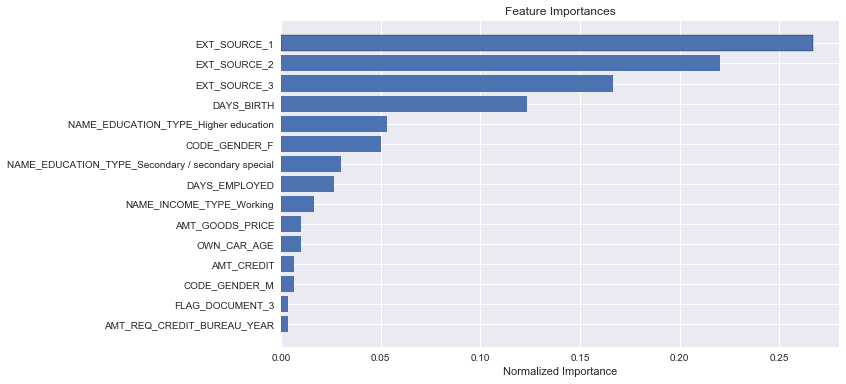

In [69]:
fi_sorted = plot_feature_importances(fi)

In [70]:
fi_raw = model(train, test)

('Training Data Shape: ', (307511, 452))
('Testing Data Shape: ', (48744, 452))


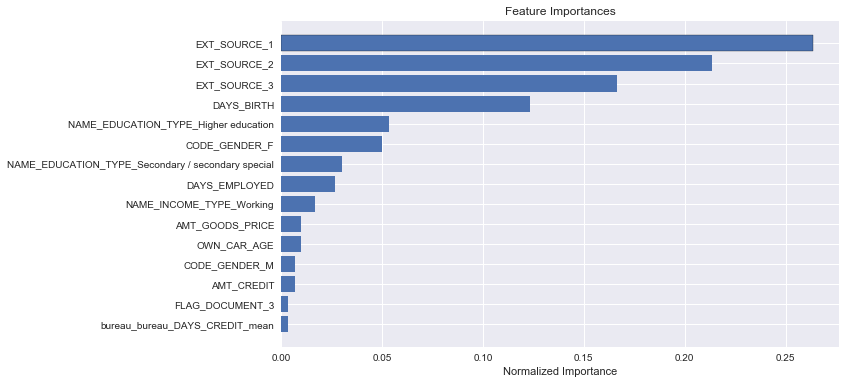

In [71]:
fi_raw_sorted = plot_feature_importances(fi_raw)

In [75]:
top_100 = list(fi_raw_sorted['feature'].data())[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'].data())]

print('%% of Top 100 Features created from the bureau data = %d.00' % len(new_features))

% of Top 100 Features created from the bureau data = 62.00


In [76]:
fi_corrs = model(train_corrs_removed, test_corrs_removed)

('Training Data Shape: ', (307511, 321))
('Testing Data Shape: ', (48744, 321))


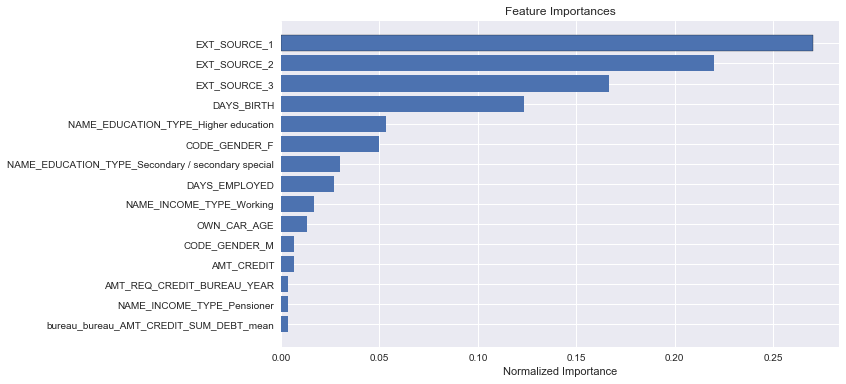

In [77]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)